In [1]:
from collections import defaultdict
import csv
import numpy as np
from numpy import genfromtxt
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate

In [2]:
def load_data():
    ''' called to load preprepared data for the lab '''
    item_train = genfromtxt('content_item_train.csv', delimiter=',')
    user_train = genfromtxt('content_user_train.csv', delimiter=',')
    y_train    = genfromtxt('content_y_train.csv', delimiter=',')
    with open('content_item_train_header.txt', newline='') as f:
        item_features = list(csv.reader(f))[0]
    with open('content_user_train_header.txt', newline='') as f:
        user_features = list(csv.reader(f))[0]
    item_vecs = genfromtxt('content_item_vecs.csv', delimiter=',')

    animal_dict = defaultdict(dict)
    count = 0

    with open('content_animal_list.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count += 1

            else:
                count += 1
                animal_id = int(line[0])
                animal_dict[animal_id]["title"] = line[1]

    return(item_train, user_train, y_train, item_features, user_features, item_vecs, animal_dict)

def pprint_train(x_train, features, vs, u_s, maxcount=5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        flist = [".0f", ".0f", ".1f",
                 ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        flist = [".0f", ".0f", ".1f",
                 ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]

    head = features[:vs]
    if vs < u_s: print("error, vector start {vs} should be greater then user start {u_s}")
    for i in range(u_s):
        head[i] = "[" + head[i] + "]"
    genres = features[vs:]
    hdr = head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0, x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append([x_train[i, 0].astype(int),
                     x_train[i, 1].astype(int),
                     x_train[i, 2].astype(float),
                     *x_train[i, 3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=flist, numalign='center')
    return table


def split_str(ifeatures, smax):
    ''' split the feature name strings to tables fit '''
    ofeatures = []
    for s in ifeatures:
        if not ' ' in s:
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return ofeatures


def print_pred_animals(y_p, item, animal_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    disp = [["Animal"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        animal_id = item[i, 0].astype(int)
        disp.append([ animal_dict[animal_id]['title']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
    return table

def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs


In [3]:
item_train, user_train, y_train, item_features, user_features, item_vecs, animal_dict = load_data()

num_user_features = user_train.shape[1] - 3
num_item_features = item_train.shape[1] - 1
uvs = 3
ivs = 3
u_s = 3
i_s = 1
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 200


In [4]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)
look = pd.read_html(pprint_train(user_train, user_features, uvs,  u_s, maxcount=5))
look[0]

,[use r_id],[co unt],[ave rage],pera watan,uku ran,akti fitas,agr esif,kesu litan,harga
0,1,12,2.0,4.0,2.0,0.0,2.0,0.0,4.0
1,2,14,2.3,3.0,1.0,2.0,3.0,4.0,1.0
2,3,9,1.5,0.0,2.0,3.0,1.0,1.0,2.0
3,4,8,1.3,0.0,0.0,1.0,4.0,2.0,1.0
4,5,5,0.8,3.0,1.0,0.0,1.0,0.0,0.0


In [5]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)
look = pd.read_html(pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False))
look[0]

,[anim al_id],Harga,ave_ch aracter,pera watan,uku ran,akti fitas,agr esif,kesu litan,harga
0,1101,15,3.5,1,1,1,1,1,1
1,1102,15,3.0,1,1,1,0,1,1
2,1103,12,2.2,1,1,1,1,0,0
3,1104,10,2.5,1,1,0,1,1,1
4,1105,12,3.8,1,1,1,1,1,1


In [6]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [3.5 3.  2.  2.5 4. ]


In [7]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


In [8]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"animal/item training data shape: {item_train.shape}")
print(f"animal/item test data shape: {item_test.shape}")

animal/item training data shape: (160, 9)
animal/item test data shape: (40, 9)


In [9]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)
look = pd.read_html(pprint_train(user_train, user_features, uvs, u_s, maxcount=5))
look[0]

,[use r_id],[co unt],[ave rage],pera watan,uku ran,akti fitas,agr esif,kesu litan,harga
0,0,0,0.2,0.5,-0.1,-1.4,0.8,-0.9,1.3
1,0,1,1.9,1.2,0.7,0.6,1.5,-0.2,0.8
2,1,2,2.2,-0.2,1.4,1.3,0.8,0.6,1.3
3,-1,1,1.1,1.2,-0.8,0.6,0.0,1.3,0.2
4,0,1,1.4,1.2,0.7,-0.1,0.8,0.6,0.2


In [10]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   38816     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   39328     ['input_2[0][0]']             
                                                                                              

In [11]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [18]:
tf.random.set_seed(1)
history=model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=100)

Epoch 1/100
5/5 [==============================] - 0s 5ms/step - loss: 6.3093e-06
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 6.1285e-06
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 5.6296e-06
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 8.2454e-06
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 8.4277e-06
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 1.1537e-05
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 1.0491e-05
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 1.9367e-05
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 2.4034e-05
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 2.4698e-05
Epoch 11/100
5/5 [==============================] - 0s 7ms/step - loss: 2.8427e-05
Epoch 12/100
5/5 [==============================] - 0s 6ms/step - loss: 2.7769e-05
Epoch 13/100


In [19]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0064


0.006353744771331549

In [24]:
import matplotlib.pyplot as plt

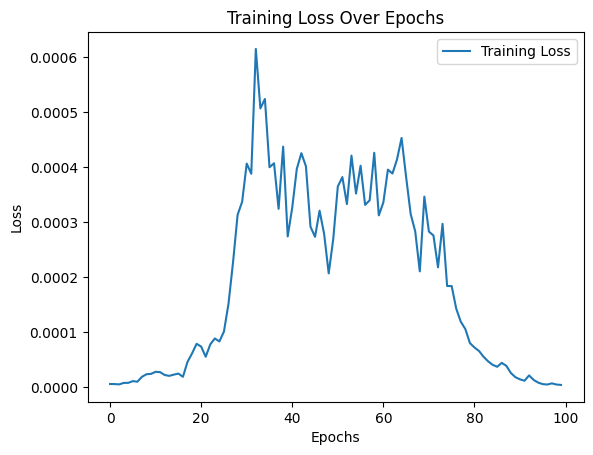

In [25]:
loss_values = history.history['loss']
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_user_id = 2023
new_ave = 2.3
new_perawatan = 0.0
new_ukuran = 0.0
new_aktifitas = 4.0
new_agresif = 4.0
new_kesulitan = 4.0
new_harapan_hidup = 4.0
new_count = 4

user_vec = np.array([[new_user_id, new_count, new_ave,
                      new_perawatan, new_ukuran, new_aktifitas, new_agresif,
                      new_kesulitan, new_harapan_hidup]])

In [ ]:
# generate and replicate the user vector to match the number animal in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, animal_dict, maxcount = 10)

4/4 [==============================] - 0s 4ms/step


Animal
Kucing Bengal
Anjing Dogo Canario
Kucing Oriental Shorthair
Kucing Siamese
Anjing Basenji
Burung Cucak Ijo
Kucing Tiffanie
Kucing Ocicat
Burung Kakatua
Burung Jalak Suren


In [ ]:
table_MN = pd.read_html(print_pred_movies(sorted_ypu, sorted_items, animal_dict, maxcount = 10))
df = table_MN[0]
df

,Animal
0,Kucing Bengal
1,Anjing Dogo Canario
2,Kucing Oriental Shorthair
3,Kucing Siamese
4,Anjing Basenji
5,Burung Cucak Ijo
6,Kucing Tiffanie
7,Kucing Ocicat
8,Burung Kakatua
9,Burung Jalak Suren
